In [30]:
import numpy as np

x_all = np.load('x_sigs.npy')
fx = np.load('features.npy')
y_mc = np.load('y_mc.npy')

# binary class labels
y_b = np.copy(y_mc)
y_b[y_b<=1] = 0
y_b[y_b>=2] = 1

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(fx)
print(scaler.mean_)
fx = scaler.transform(fx)

print(np.mean(fx))
print(np.std(fx))

scaler = StandardScaler()
scaler.fit(x_all)
print(scaler.mean_)
x_all = scaler.transform(x_all)

print(np.mean(x_all))
print(np.std(x_all))

# train, test  == stratified
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(fx, y_b)

print(sss)       

for train_index, test_index in sss.split(fx, y_b):
    #print("TRAIN:", train_index, "TEST:", test_index)
    Xs_train, Xf_train, Xs_test, Xf_test = x_all[train_index], fx[train_index], x_all[test_index], fx[test_index]
    y_train, y_test = y_b[train_index], y_b[test_index]
    
    
print(Xs_train.shape)
print(Xf_train.shape)
print(Xs_test.shape)
print(Xf_test.shape)

[3.4163018e+09 5.3098379e+04 1.9286356e+03 2.8326578e+04 1.4957513e-01
 2.2935305e+00 1.5088350e+00 1.8876824e+06 2.2846521e+04 3.1334696e+01]
1.0986328e-07
0.99999994
[1939.5435 1939.7426 1939.4132 1939.6099 1939.8888 1938.5876 1935.9607
 1935.033  1933.0187 1929.4152 1927.6764 1927.1282 1924.5441 1928.1434
 1932.6597 1935.5975 1940.7992 1940.5189 1938.0455 1938.1248 1942.8406
 1948.7866 1948.5162 1944.9203 1942.4865 1942.1248 1939.8838 1935.405
 1934.4564 1930.1993 1929.1168 1935.671  1940.3977 1938.3549 1937.1805
 1936.7863 1932.7354 1931.3853 1934.1587 1934.88   1934.7776 1937.382
 1940.5823 1942.846  1947.0247 1945.3303 1937.2406 1931.9583 1927.4333
 1926.7278 1929.728  1935.8071 1939.8489 1939.0819 1936.4929 1936.2495
 1934.8951 1932.2361 1932.0349 1931.3812 1930.2816 1929.3276 1932.3474
 1937.6652 1938.4252 1934.038  1927.25   1921.6204 1916.2822 1921.0366
 1928.8647 1927.1609 1921.2809 1922.6769 1927.9186 1929.7268 1930.3861
 1933.2346 1935.9164 1937.472  1940.6082 1936.9957 19

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)
(800, 905)
(800, 10)
(200, 905)
(200, 10)


In [31]:
Xs_train = np.reshape(Xs_train, (800,905,1))
print(Xs_train.shape)

Xs_test = np.reshape(Xs_test, (200,905,1))
print(Xs_test.shape)

(800, 905, 1)
(200, 905, 1)


In [32]:
import keras
from keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [33]:
import math
def step_decay(epoch, triangular = False):
    initial_lrate = 0.1
    drop = 0.7
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if triangular == True and epoch%2 == 1:
        lrate += lrate
    return lrate

def step_decay_tri(epoch, triangular = True):
    initial_lrate = 0.1
    drop = 0.7
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if triangular == True and epoch%2 == 1:
        lrate += lrate
    return lrate

In [42]:
import math
def step_decay(epoch, triangular = False):
    initial_lrate = 0.1
    drop = 0.7
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if triangular == True and epoch%2 == 1:
        lrate += lrate
    return lrate

def step_decay_tri(epoch, triangular = True):
    initial_lrate = 0.1
    drop = 0.7
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if triangular == True and epoch%2 == 1:
        lrate += lrate
    return lrate

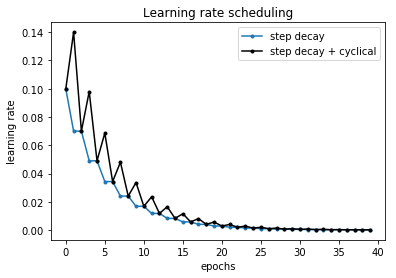

In [44]:
import matplotlib.pyplot as plt
y = [step_decay(x) for x in range(40)]
y_tri = [step_decay(x, True) for x in range(40)]
#print(y)
plt.plot(y, '.-')
plt.plot(y_tri, '.-k')
plt.title('Learning rate scheduling')
plt.xlabel('epochs')
plt.ylabel('learning rate')
plt.legend(['step decay', 'step decay + cyclical'])
plt.savefig('learning_rate.png', dpi=1000)
plt.show()

In [45]:
from keras.models import Model
from keras.layers import LSTM, Dense, Dropout, Input, ConvLSTM2D, Flatten, Add, Concatenate, Dot, Multiply
from keras.layers import Maximum, Average, Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import math



lrate = LearningRateScheduler(step_decay)

neurons = (2<<5) - 1

t_len = 905
n_class = 2


x_i = Input(shape = (905,1))
x_i2 = Input(shape = (10,))

# bf
x = LSTM(units=neurons, return_sequences = True, kernel_initializer = keras.initializers.he_normal(seed=19),
        recurrent_initializer = keras.initializers.he_normal(seed=19), kernel_regularizer = keras.regularizers.l1(0.01),
        recurrent_regularizer = keras.regularizers.l2(0.01), recurrent_dropout = 0.2)(x_i)
x = Dropout(0.4)(x)

#b1
x_pa = LSTM(units=neurons, kernel_initializer = keras.initializers.he_normal(seed=19),
        recurrent_initializer = keras.initializers.he_normal(seed=19), kernel_regularizer = keras.regularizers.l1(0.01),
        recurrent_regularizer = keras.regularizers.l2(0.01), recurrent_dropout = 0.2)(x)
x = Activation('relu')(x_pa)
x = Dropout(0.1)(x)

#b2
x_pa2 = Dense(neurons, kernel_initializer = keras.initializers.he_normal(seed=19),
             bias_initializer = keras.initializers.he_normal(seed=19),
             kernel_regularizer = keras.regularizers.l1(0.01),
             bias_regularizer = keras.regularizers.l1(0.01))(x_i2)
x2 = Activation('relu')(x_pa2)
x2 = Dropout(0.1)(x2)
x_dot = Dot(axes=1, normalize=True)([x2, x]) 

# Dot gives 75% test axes=1, normalize=True
# Add 33% Mul got stuck at 75% Max got stuck 70%
# Average stuck 70%

x_add = Concatenate()([x_dot, x_pa])
x_f = Activation('relu')(x_add)

x_add2 = Concatenate()([x_dot, x_pa2])
x_f2 = Activation('relu')(x_add2)

x_dot2 = Dot(axes=1, normalize=True)([x_f, x_f2])

x_add = Concatenate()([x_dot2, x_pa])
x_f = Activation('relu')(x_add)

x_add2 = Concatenate()([x_dot2, x_pa2])
x_f2 = Activation('relu')(x_add2)

x_dot3 = Dot(axes=1, normalize=True)([x_f, x_f2])

x_add = Concatenate()([x_dot3, x_pa])
x_f = Activation('relu')(x_add)

x_add2 = Concatenate()([x_dot3, x_pa2])
x_f2 = Activation('relu')(x_add2)

x_dot4 = Dot(axes=1, normalize=True)([x_f, x_f2])

x_add = Concatenate()([x_dot4, x_pa])
x_f = Activation('relu')(x_add)

x_add2 = Concatenate()([x_dot4, x_pa2])
x_f2 = Activation('relu')(x_add2)

x_dot5 = Dot(axes=1, normalize=True)([x_f, x_f2])

x_add = Concatenate()([x_dot5, x_i2])
x_f = Activation('relu')(x_add)

x_f = Dense(128, activation='relu', kernel_initializer = keras.initializers.he_normal(seed=19),
             bias_initializer = keras.initializers.he_normal(seed=19),
             kernel_regularizer = keras.regularizers.l1(0.01),
             bias_regularizer = keras.regularizers.l1(0.01))(x_f)


x = Dropout(0.2)(x_f)
x_o = Dense(n_class, activation='softmax')(x)


model = Model([x_i, x_i2], x_o)

# checkpoint
filepath="dot_res_lstm-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, lrate]

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [46]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 905, 1)       0                                            
__________________________________________________________________________________________________
lstm_17 (LSTM)                  (None, 905, 63)      16380       input_21[0][0]                   
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 905, 63)      0           lstm_17[0][0]                    
__________________________________________________________________________________________________
dense_18 (

In [47]:
hist = model.fit([Xs_train, Xf_train], y_train, epochs = 30, batch_size = 64, validation_split=0.15,
        callbacks=callbacks_list)

Train on 680 samples, validate on 120 samples
Epoch 1/30
680/680 [==============================] - 30s 45ms/step - loss: 19.7056 - acc: 0.6074 - val_loss: 10.1605 - val_acc: 0.6000

Epoch 00001: val_acc improved from -inf to 0.60000, saving model to dot_res_lstm-01-0.60.hdf5
Epoch 2/30
680/680 [==============================] - 24s 35ms/step - loss: 7.3456 - acc: 0.6897 - val_loss: 4.9276 - val_acc: 0.7583

Epoch 00002: val_acc improved from 0.60000 to 0.75833, saving model to dot_res_lstm-02-0.76.hdf5
Epoch 3/30
680/680 [==============================] - 25s 36ms/step - loss: 4.2579 - acc: 0.6941 - val_loss: 3.3175 - val_acc: 0.7583

Epoch 00003: val_acc did not improve from 0.75833
Epoch 4/30
680/680 [==============================] - 25s 37ms/step - loss: 2.7627 - acc: 0.7000 - val_loss: 2.2418 - val_acc: 0.7167

Epoch 00004: val_acc did not improve from 0.75833
Epoch 5/30
680/680 [==============================] - 23s 33ms/step - loss: 2.1711 - acc: 0.6779 - val_loss: 1.9689 - val

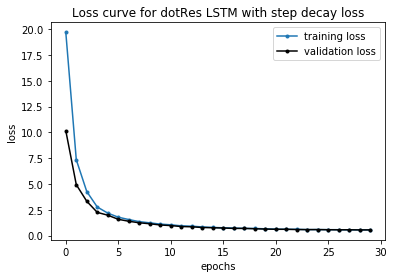

In [49]:
plt.plot(hist.history['loss'], '.-')
plt.plot(hist.history['val_loss'], '.-k')
plt.title('Loss curve for dotRes LSTM with step decay loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])
plt.savefig('loss_dotres_step_decay.png', dpi=1000)
plt.show()

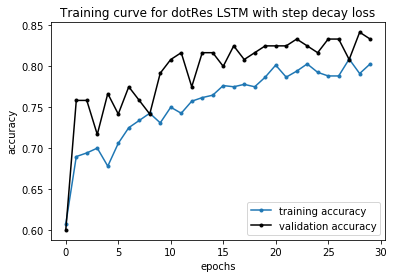

In [50]:
plt.plot(hist.history['acc'], '.-')
plt.plot(hist.history['val_acc'], '.-k')
plt.title('Training curve for dotRes LSTM with step decay loss')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.savefig('training_dotres_step_decay.png', dpi=1000)
plt.show()

In [61]:
'''
source: https://www.quora.com/How-can-I-explain-the-fact-that-test-accuracy-is-much-higher-than-train-accuracy

Well, if you’re using neural networks AND following good regularization practices (read: very liberal usage of Dropout), it’s basically assured that your test accuracy, at it’s best, will be better than your training accuracy.

That said, a good follow-up reaction to that answer is ‘What? Why?’.

Well, think of using Dropout as nearly identical to forcing your neural network to become a very large collection of weak classifiers (in other words, an ensemble). As the name implies, an individual weak classifier doesn’t have much classification accuracy, they only become powerful once you string a bunch of them together.

Dropout, during training, slices off some random collection of these classifiers. Thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves.

'''

'\nsource: https://www.quora.com/How-can-I-explain-the-fact-that-test-accuracy-is-much-higher-than-train-accuracy\n\nWell, if you’re using neural networks AND following good regularization practices (read: very liberal usage of Dropout), it’s basically assured that your test accuracy, at it’s best, will be better than your training accuracy.\n\nThat said, a good follow-up reaction to that answer is ‘What? Why?’.\n\nWell, think of using Dropout as nearly identical to forcing your neural network to become a very large collection of weak classifiers (in other words, an ensemble). As the name implies, an individual weak classifier doesn’t have much classification accuracy, they only become powerful once you string a bunch of them together.\n\nDropout, during training, slices off some random collection of these classifiers. Thus, training accuracy suffers.\n\nDropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing ac

In [51]:
model.evaluate([Xs_test, Xf_test], y_test)

200/200 [==============================] - 2s 8ms/step


[0.5584638833999633, 0.795]

In [55]:
from sklearn.metrics import precision_recall_fscore_support
y_pred = model.predict([Xs_test, Xf_test])

In [57]:
y_pred = y_pred.argmax(axis=-1)

In [59]:
y_true = y_b[test_index]
precision_recall_fscore_support(y_true, y_pred, average='binary')

(0.8206896551724138, 0.8880597014925373, 0.8530465949820788, None)

In [62]:
'''

source: https://towardsdatascience.com/precision-vs-recall-386cf9f89488

Precision and recall are two extremely important model evaluation metrics. While precision refers to the percentage of your results which are relevant, recall refers to the percentage of total relevant results correctly classified by your algorithm. Unfortunately, it is not possible to maximize both these metrics at the same time, as one comes at the cost of another. For simplicity, there is another metric available, called F-1 score, which is a harmonic mean of precision and recall. For problems where both precision and recall are important, one can select a model which maximizes this F-1 score. For other problems, a trade-off is needed, and a decision has to be made whether to maximize precision, or recall.

'''

'\n\nsource: https://towardsdatascience.com/precision-vs-recall-386cf9f89488\n\nPrecision and recall are two extremely important model evaluation metrics. While precision refers to the percentage of your results which are relevant, recall refers to the percentage of total relevant results correctly classified by your algorithm. Unfortunately, it is not possible to maximize both these metrics at the same time, as one comes at the cost of another. For simplicity, there is another metric available, called F-1 score, which is a harmonic mean of precision and recall. For problems where both precision and recall are important, one can select a model which maximizes this F-1 score. For other problems, a trade-off is needed, and a decision has to be made whether to maximize precision, or recall.\n\n'

In [52]:
import pydot
import graphviz
from keras.utils.vis_utils import plot_model

In [53]:
plot_model(model, to_file='dotreslstm_plot.png')

In [63]:
model.save('dotres_LSTM_step_decay.h5')

In [64]:
lrate2 = LearningRateScheduler(step_decay_tri)
# checkpoint
filepath="dot_res_lstm_nov_loss-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, lrate2]

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [65]:
hist = model.fit([Xs_train, Xf_train], y_train, epochs = 30, batch_size = 64, validation_split=0.15,
        callbacks=callbacks_list)

Train on 680 samples, validate on 120 samples
Epoch 1/30
680/680 [==============================] - 37s 55ms/step - loss: 12.6569 - acc: 0.6765 - val_loss: 5.2743 - val_acc: 0.7500

Epoch 00001: val_acc improved from -inf to 0.75000, saving model to dot_res_lstm_nov_loss-01-0.75.hdf5
Epoch 2/30
680/680 [==============================] - 27s 39ms/step - loss: 5.9286 - acc: 0.6735 - val_loss: 2.3229 - val_acc: 0.7333

Epoch 00002: val_acc did not improve from 0.75000
Epoch 3/30
680/680 [==============================] - 29s 43ms/step - loss: 3.5406 - acc: 0.6706 - val_loss: 3.0105 - val_acc: 0.7500

Epoch 00003: val_acc improved from 0.75000 to 0.75000, saving model to dot_res_lstm_nov_loss-03-0.75.hdf5
Epoch 4/30
680/680 [==============================] - 32s 47ms/step - loss: 2.4748 - acc: 0.7103 - val_loss: 2.3664 - val_acc: 0.7667

Epoch 00004: val_acc improved from 0.75000 to 0.76667, saving model to dot_res_lstm_nov_loss-04-0.77.hdf5
Epoch 5/30
680/680 [============================

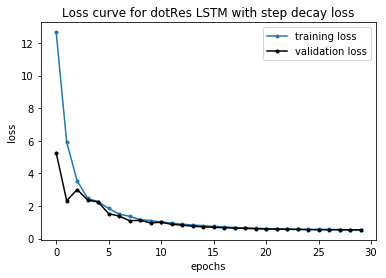

In [67]:
plt.plot(hist.history['loss'], '.-')
plt.plot(hist.history['val_loss'], '.-k')
plt.title('Loss curve for dotRes LSTM with spiking step decay loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])
plt.savefig('loss_dotres_nov_loss.png', dpi=1000)
plt.show()

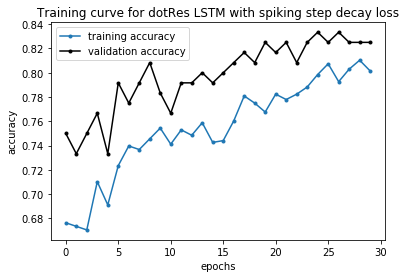

In [68]:
plt.plot(hist.history['acc'], '.-')
plt.plot(hist.history['val_acc'], '.-k')
plt.title('Training curve for dotRes LSTM with spiking step decay loss')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.savefig('training_dotres_nov_loss.png', dpi=1000)
plt.show()

In [69]:
model.evaluate([Xs_test, Xf_test], y_test)

200/200 [==============================] - 2s 9ms/step


[0.5585943722724914, 0.775]

In [72]:
np.save('Xs_train.npy', Xs_train)

In [73]:
np.save('Xf_train.npy', Xf_train)

In [74]:
np.save('Xs_test.npy', Xs_test)

In [75]:
np.save('Xf_test.npy', Xf_test)

In [76]:
np.save('y_train.npy', y_train)

In [77]:
np.save('y_test.npy', y_test)